In [4]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

In [5]:

def hay_adyacentes(solucion, x, y):
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            xi = x + i
            yi = y + j
            if (i != 0 or j != 0) and 0 <= xi < len(solucion) and 0 <= yi < len(solucion[0]):
                if solucion[xi][yi] == 1:
                    return True

    return False


def es_posicion_valida(matriz, barco, x, y, es_horizontal, restricciones_fils, restricciones_cols):
    if es_horizontal:
        # si no entra en la fila, no se puede agregar
        if y + barco > len(matriz[0]):
            return False

        # si el barco ocupa más de lo pedido en la restricción de la fila, no se puede agregar
        if barco > restricciones_fils[x]:
            return False

        for i in range(barco):
            if matriz[x][y + i] == 1 or hay_adyacentes(matriz, x, y + i) or restricciones_cols[y + i] <= 0:
                return False
        return True
    else:
        if x + barco > len(matriz):
            return False

        if barco > restricciones_cols[y]:
            return False

        for i in range(barco):
            if matriz[x+i][y] == 1 or hay_adyacentes(matriz, x+i, y) or restricciones_fils[x+i] <= 0:
                return False
        return True



def buscar_posicion(matriz, barco, restricciones_fils, restricciones_cols):
    max_restriccion_fila = max(restricciones_fils)
    max_restriccion_columna = max(restricciones_cols)
    if max_restriccion_fila >= max_restriccion_columna:
        fila = restricciones_fils.index(max_restriccion_fila)
        for j in range(len(matriz[0])):
            if es_posicion_valida(matriz, barco, fila, j, True, restricciones_fils, restricciones_cols):
                return fila, j, True

    else:
        columna = restricciones_cols.index(max_restriccion_columna)
        for i in range(len(matriz)):
            if es_posicion_valida(matriz, barco, i, columna, False, restricciones_fils, restricciones_cols):
                return i, columna, False

    return -1, -1, False

def colocar_barco_y_ocupar_casilleros(matriz, barco, x, y, es_horizontal, restricciones_fils, restricciones_cols):
    if barco == 1:
        matriz[x][y] = 1
        restricciones_fils[x] -= 1
        restricciones_cols[y] -= 1
    elif es_horizontal:
        for i in range(barco):
            matriz[x][y + i] = 1
            restricciones_fils[x] -= 1
            restricciones_cols[y+i] -= 1
    else:
        for i in range(barco):
            matriz[x + i][y] = 1
            restricciones_fils[x+i] -= 1
            restricciones_cols[y] -= 1


# asumo que recibo una matriz llena de 0s
def aproximacion(matriz, barcos, restricciones_fils, restricciones_cols):
    barcos.sort(reverse=True)

    for barco in barcos:  # empiezo con los de mayor tamaño
        x, y, es_horizontal = buscar_posicion(
            matriz, barco, restricciones_fils, restricciones_cols)
        if x != -1:
            colocar_barco_y_ocupar_casilleros(
                matriz, barco, x, y, es_horizontal, restricciones_fils, restricciones_cols)

    return matriz


In [6]:

def hay_adyacentes(solucion, x, y):
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            xi = x + i
            yi = y + j
            if (i != 0 or j != 0) and 0 <= xi < len(solucion) and 0 <= yi < len(solucion[0]):
                if solucion[xi][yi] == 1:
                    return True
    return False


def se_puede_ubicar(matriz, fil, col, largo, orientacion, restricciones_fil, restricciones_col):
    n, m = len(matriz), len(matriz[0])
    if (orientacion == "horizontal" and col + largo > m) or (orientacion == "vertical" and fil + largo > n):
        return False

    for k in range(largo):
        x, y = (fil, col + k) if orientacion == "horizontal" else (fil + k, col)
        if matriz[x][y] == 1 or hay_adyacentes(matriz, x, y):
            return False

    if orientacion == "horizontal":
        if sum(matriz[fil]) + largo > restricciones_fil[fil]:
            return False
        for i in range(largo):
            if sum(matriz[r][col + i] for r in range(n)) + 1 > restricciones_col[col + i]:
                return False
    elif orientacion == "vertical":
        if sum(matriz[r][col] for r in range(n)) + largo > restricciones_col[col]:
            return False
        for i in range(largo):
            if sum(matriz[fil + i]) + 1 > restricciones_fil[fil + i]:
                return False

    return True


def actualizar_posicion_matriz(matriz, i, j, largo, orientacion, value):
    for k in range(largo):
        fil, col = (i, j + k) if orientacion == "horizontal" else (i + k, j)
        matriz[fil][col] = value


def calcular_demanda(matriz, restricciones_fil, restricciones_col):
    n, m = len(matriz), len(matriz[0])
    suma_filas = sum(
        [sum(matriz[i]) for i in range(n)])
    suma_columnas = sum(
        [sum(matriz[i][j] for i in range(n)) for j in range(m)])
    total_filas = sum(restricciones_fil)
    total_cols = sum(restricciones_col)
    demanda_llena = suma_columnas + suma_filas
    demanda_total = total_filas + total_cols
    return demanda_llena, demanda_total


def batalla_naval(matriz, barcos, restricciones_fil, restricciones_col):
    barcos = sorted(barcos, reverse=True)  # ordeno para mejorar la complejidad
    posiciones = [None] * len(barcos)
    mejor_solucion = matriz
    return batalla_naval_bk(matriz, barcos, restricciones_fil, restricciones_col, 0, posiciones, mejor_solucion, 0, posiciones)


def batalla_naval_bk(matriz, barcos, restricciones_fil, restricciones_col, index, posiciones, mejor_solucion, mejor_demanda, mejor_posiciones):
    demanda_parcial, _ = calcular_demanda(
        matriz, restricciones_fil, restricciones_col)
    if index == len(barcos):
        if demanda_parcial > mejor_demanda:
            return demanda_parcial, [col[:] for col in matriz], posiciones[:]
        return mejor_demanda, mejor_solucion, mejor_posiciones

    if index > len(barcos):
        return mejor_demanda, mejor_solucion, mejor_posiciones

    if demanda_parcial + sum(barcos[i] for i in range(index, len(barcos))) < mejor_demanda:
        return mejor_demanda, mejor_solucion, mejor_posiciones

    largo_barco = barcos[index]
    for i in range(len(matriz)):
        for j in range(len(matriz[0])):
            if matriz[i][j] == 1:
                continue
            for orientacion in ["horizontal", "vertical"]:
                if se_puede_ubicar(matriz, i, j, largo_barco, orientacion, restricciones_fil, restricciones_col):
                    posiciones[index] = (
                        (i, j), (i + largo_barco - 1, j) if orientacion == "vertical" else (i, j + largo_barco - 1))

                    actualizar_posicion_matriz(
                        matriz, i, j, largo_barco, orientacion, 1)

                    posible_demanda, posible_solucion, posible_posiciones = batalla_naval_bk(
                        matriz, barcos, restricciones_fil, restricciones_col, index + 1, posiciones, mejor_solucion, mejor_demanda, mejor_posiciones)
                    if posible_demanda > mejor_demanda:
                        mejor_demanda = posible_demanda
                        mejor_solucion = posible_solucion
                        mejor_posiciones = posible_posiciones

                    actualizar_posicion_matriz(
                        matriz, i, j, largo_barco, orientacion, 0)
                    posiciones[index] = None

    posible_demanda2, posible_solucion2, posible_posiciones2 = batalla_naval_bk(
        matriz, barcos, restricciones_fil, restricciones_col, index + 1, posiciones, mejor_solucion, mejor_demanda, mejor_posiciones)
    if posible_demanda2 > mejor_demanda:
        mejor_demanda = posible_demanda2
        mejor_solucion = posible_solucion2[:]
        mejor_posiciones = posible_posiciones2[:]

    return mejor_demanda, mejor_solucion, mejor_posiciones



def backtracking(matriz, barcos, restricciones_fil, restricciones_col):
    barcos = sorted(barcos, reverse=True)  # ordeno para mejorar la complejidad
    posiciones = [None] * len(barcos)
    mejor_solucion = matriz
    return batalla_naval_bk(matriz, barcos, restricciones_fil, restricciones_col, 0, posiciones, mejor_solucion, 0, posiciones)


In [7]:
def calcular_demanda2(matriz, restricciones_fil, restricciones_col):
    n, m = len(matriz), len(matriz[0])
    suma_filas = sum(
        [sum(matriz[i]) for i in range(n)])
    suma_columnas = sum(
        [sum(matriz[i][j] for i in range(n)) for j in range(m)])
    total_filas = sum(restricciones_fil)
    total_cols = sum(restricciones_col)
    demanda_llena = suma_columnas + suma_filas
    demanda_total = total_filas + total_cols
    return demanda_llena, demanda_total

In [8]:
from copy import deepcopy


def ejecutar_ejemplo_aleatorio(matriz, barcos, restricciones_fil, restricciones_col):
    matriz_copia = deepcopy(matriz)
    matriz_copia2 = deepcopy(matriz)
    restricciones_fil_copia = deepcopy(restricciones_fil)
    restricciones_fil_copia2 = deepcopy(restricciones_fil)
    restricciones_col_copia = deepcopy(restricciones_col)
    restricciones_col_copia2 = deepcopy(restricciones_col)

    start_time = time.time()
    demanda_exacta, solucion_exacta, _ = batalla_naval(
        matriz_copia, barcos, restricciones_fil_copia, restricciones_col_copia)
    tiempo_exacto = time.time() - start_time

    _, demanda_total_exacta = calcular_demanda(
        solucion_exacta, restricciones_fil_copia, restricciones_col_copia)

    start_time = time.time()
    solucion_aproximada = aproximacion(
        matriz_copia2, barcos, restricciones_fil_copia2, restricciones_col_copia2)
    tiempo_aproximado = time.time() - start_time

    demanda_aproximada, _ = calcular_demanda2(
        solucion_aproximada, restricciones_fil_copia2, restricciones_col_copia2)

    # Impresión de resultados
    print("Solución Exacta:")
    for fila in solucion_exacta:
        print("".join(["1" if i == 1 else "-" for i in fila]))
    print("Demanda Cumplida Exacta:", demanda_exacta)
    print("Demanda Total Exacta:", demanda_total_exacta)
    print("Tiempo Exacto:", tiempo_exacto)

    print("\nSolución Aproximada:")
    for fila in solucion_aproximada:
        print("".join(["1" if i == 1 else "." for i in fila]))
    print("Demanda Cumplida Aproximada:", demanda_aproximada)
    print("Tiempo Aproximado:", tiempo_aproximado)

    return solucion_exacta, demanda_exacta, solucion_aproximada, demanda_aproximada, tiempo_exacto, tiempo_aproximado

In [9]:
import time
matriz1 = [[0]*2 for _ in range(2)]
barcos1 = [1]
res_fil1 = [1,1]
res_col1 = [1,1]

_, _, _, _, tiempo_exacto1, tiempo_aproximado1 = ejecutar_ejemplo_aleatorio(
    matriz1, barcos1, res_fil1, res_col1)
print("")
matriz2 = [[0] * 3 for _ in range(3)]
barcos2 = [2,1,1]
res_fil2 = [2,1,2]
res_col2 = [2,2,1]

_, _, _, _, tiempo_exacto2, tiempo_aproximado2 = ejecutar_ejemplo_aleatorio(
    matriz2, barcos2, res_fil2, res_col2)

print("")

matriz3 = [[0] * 3 for _ in range(4)]
barcos3 = [4,1,1]
res_fil3 = [1,1,1,1]
res_col3 = [4,0,0]

_, _, _, _, tiempo_exacto3, tiempo_aproximado3 = ejecutar_ejemplo_aleatorio(
    matriz3, barcos3, res_fil3, res_col3)


matriz4 = [[0] * 4 for _ in range(4)]
barcos4 = []
res_fil4 = [1,2,1,2]
res_col4 = [2,1,2,1]

_, _, _, _, tiempo_exacto4, tiempo_aproximado4 = ejecutar_ejemplo_aleatorio(
    matriz4, barcos4, res_fil4, res_col4)


matriz5 = [[0] * 4 for _ in range(4)]
barcos5 = [4,3,3,2]
res_fil5 = [4,4,4,4]
res_col5 = [4,4,4,4]

_, _, _, _, tiempo_exacto5, tiempo_aproximado5 = ejecutar_ejemplo_aleatorio(
    matriz5, barcos5, res_fil5, res_col5)


matriz6 = [[0] * 5 for _ in range(5)]
barcos6 = [1,2]
res_fil6 = [0,0, 1, 0, 0]
res_col6 = [0,0,1,0,0]

_, _, _, _, tiempo_exacto6, tiempo_aproximado6 = ejecutar_ejemplo_aleatorio(
    matriz6, barcos6, res_fil6, res_col6)

Solución Exacta:
1-
--
Demanda Cumplida Exacta: 2
Demanda Total Exacta: 4
Tiempo Exacto: 0.00022101402282714844

Solución Aproximada:
1.
..
Demanda Cumplida Aproximada: 2
Tiempo Aproximado: 2.2411346435546875e-05

Solución Exacta:
11-
---
1-1
Demanda Cumplida Exacta: 8
Demanda Total Exacta: 10
Tiempo Exacto: 0.0006306171417236328

Solución Aproximada:
11.
...
1..
Demanda Cumplida Aproximada: 6
Tiempo Aproximado: 4.601478576660156e-05

Solución Exacta:
1--
1--
1--
1--
Demanda Cumplida Exacta: 8
Demanda Total Exacta: 8
Tiempo Exacto: 0.00031566619873046875

Solución Aproximada:
1..
1..
1..
1..
Demanda Cumplida Aproximada: 8
Tiempo Aproximado: 5.054473876953125e-05
Solución Exacta:
----
----
----
----
Demanda Cumplida Exacta: 0
Demanda Total Exacta: 12
Tiempo Exacto: 1.6450881958007812e-05

Solución Aproximada:
....
....
....
....
Demanda Cumplida Aproximada: 0
Tiempo Aproximado: 1.6689300537109375e-06
Solución Exacta:
1111
----
111-
----
Demanda Cumplida Exacta: 14
Demanda Total Exacta: 

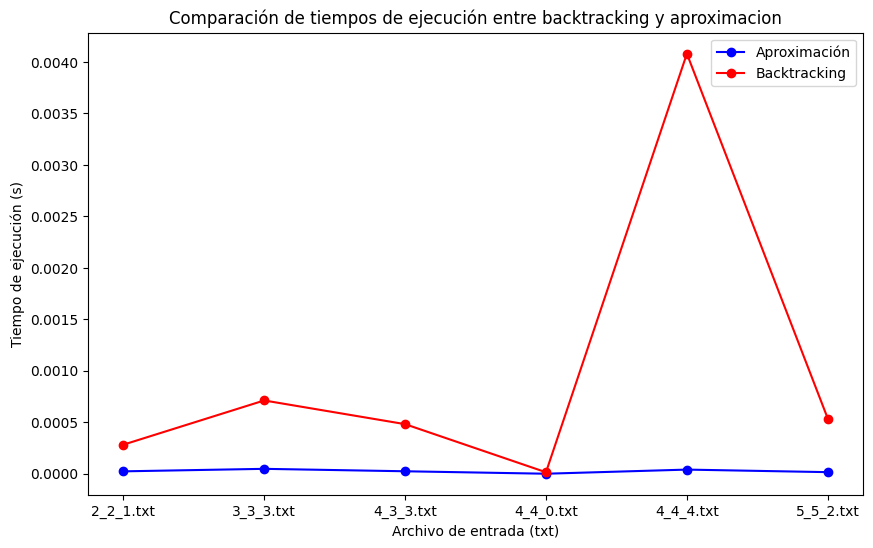

In [10]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

n_tamanios = ['2_2_1.txt', '3_3_3.txt', '4_3_3.txt', '4_4_0.txt' , '4_4_4.txt',  '5_5_2.txt']
tiempos_aprox = [0.00002431, 0.00004863, 0.00002503, 0.0000011920, 0.0000412464, 0.000016450881]
tiempos_exacto = [0.000283, 0.000712633, 0.00048255, 0.0000154, 0.00407981, 0.000536441]
plt.figure(figsize=(10, 6))
plt.plot(n_tamanios, tiempos_aprox, 'o-', label="Aproximación", color='blue')
plt.plot(n_tamanios, tiempos_exacto, 'o-', label="Backtracking", color='red')

plt.xlabel('Archivo de entrada (txt)')
plt.ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.title("Comparación de tiempos de ejecución entre backtracking y aproximacion")
plt.show()

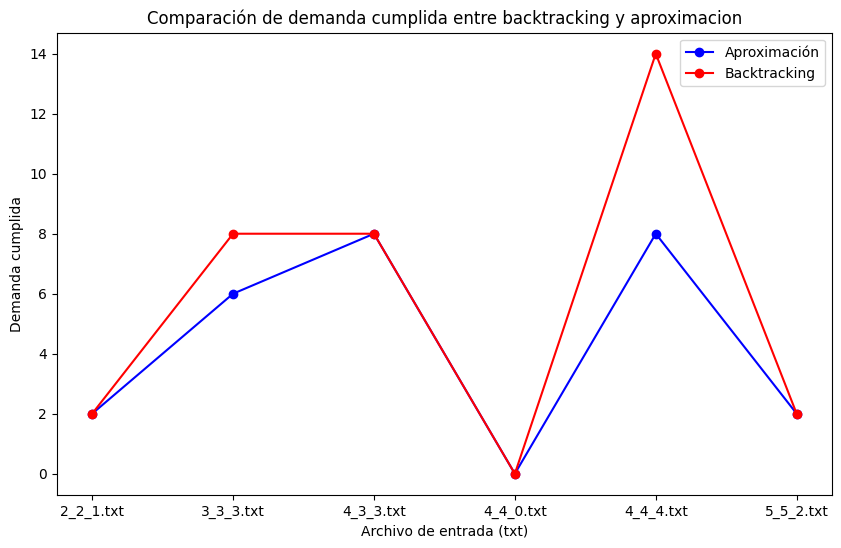

In [11]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

n_tamanios = ['2_2_1.txt', '3_3_3.txt', '4_3_3.txt', '4_4_0.txt' , '4_4_4.txt',  '5_5_2.txt']
tiempos_exacto = [2,8,8,0,14,2]
tiempos_aprox = [2,6,8,0,8, 2]
plt.figure(figsize=(10, 6))
plt.plot(n_tamanios, tiempos_aprox, 'o-', label="Aproximación", color='blue')
plt.plot(n_tamanios, tiempos_exacto, 'o-', label="Backtracking", color='red')

plt.xlabel('Archivo de entrada (txt)')
plt.ylabel('Demanda cumplida')
plt.legend()
plt.title("Comparación de demanda cumplida entre backtracking y aproximacion")
plt.show()




In [12]:

import time
matriz1 = [[0]*5 for _ in range(3)]
barcos1 = [5, 3, 2]
res_fil1 = [5, 2, 3]
res_col1 = [1, 1, 2, 2, 2]

_, _, _, _, tiempo_exacto1, tiempo_aproximado1 = ejecutar_ejemplo_aleatorio(
    matriz1, barcos1, res_fil1, res_col1)
print("")
matriz2 = [[0] * 5 for _ in range(5)]
barcos2 = [5, 4, 3]
res_fil2 = [5, 5, 4, 3, 0]
res_col2 = [5, 5, 0, 2, 5]

_, _, _, _, tiempo_exacto2, tiempo_aproximado2 = ejecutar_ejemplo_aleatorio(
    matriz2, barcos2, res_fil2, res_col2)

print("")

matriz3 = [[0] * 6 for _ in range(6)]
barcos3 = [6, 5, 4, 3]
res_fil3 = [6, 5, 4, 3, 0, 0]
res_col3 = [3, 3, 3, 5, 5, 5]

_, _, _, _, tiempo_exacto3, tiempo_aproximado3 = ejecutar_ejemplo_aleatorio(
    matriz3, barcos3, res_fil3, res_col3)

Solución Exacta:
11111
-----
--111
Demanda Cumplida Exacta: 16
Demanda Total Exacta: 18
Tiempo Exacto: 0.00039649009704589844

Solución Aproximada:
11111
.....
..111
Demanda Cumplida Aproximada: 16
Tiempo Aproximado: 8.535385131835938e-05

Solución Exacta:
1---1
1---1
1---1
1----
-----
Demanda Cumplida Exacta: 14
Demanda Total Exacta: 34
Tiempo Exacto: 0.0008716583251953125

Solución Aproximada:
.....
.....
.....
.....
.....
Demanda Cumplida Aproximada: 0
Tiempo Aproximado: 5.435943603515625e-05

Solución Exacta:
111111
------
1111--
------
------
------
Demanda Cumplida Exacta: 20
Demanda Total Exacta: 42
Tiempo Exacto: 0.0013859272003173828

Solución Aproximada:
111111
......
......
......
......
......
Demanda Cumplida Aproximada: 12
Tiempo Aproximado: 4.839897155761719e-05


In [13]:
#asdasdasd

In [14]:
matriz_10_3_3 = [[0] * 3 for _ in range(10)]
barcos_10_3_3 = [3, 3, 4]
res_fil_10_3_3 = [1,0,1,0,1,0,0,1,1,1]
res_col_10_3_3 = [1, 4, 3]


_, _, _, _, tiempo_exacto_10_3_3, tiempo_aproximado_10_3_3 = ejecutar_ejemplo_aleatorio(
    matriz_10_3_3, barcos_10_3_3, res_fil_10_3_3, res_col_10_3_3)


Solución Exacta:
---
---
---
---
---
---
---
-1-
-1-
-1-
Demanda Cumplida Exacta: 6
Demanda Total Exacta: 14
Tiempo Exacto: 0.0018718242645263672

Solución Aproximada:
...
...
...
...
...
...
...
.1.
.1.
.1.
Demanda Cumplida Aproximada: 6
Tiempo Aproximado: 0.00021982192993164062


In [15]:
matriz_3_3_2 = [[0] * 3 for _ in range(3)]
barcos_3_3_2 = [3, 1]
res_fil_3_3_2 = [3, 1, 2]
res_col_3_3_2 = [3, 2, 0]


_, _, _, _, tiempo_exacto_3_3_2, tiempo_aproximado_3_3_2 = ejecutar_ejemplo_aleatorio(
    matriz_3_3_2, barcos_3_3_2, res_fil_3_3_2, res_col_3_3_2)


Solución Exacta:
1--
1--
1--
Demanda Cumplida Exacta: 6
Demanda Total Exacta: 11
Tiempo Exacto: 0.0002300739288330078

Solución Aproximada:
1..
...
...
Demanda Cumplida Aproximada: 2
Tiempo Aproximado: 2.47955322265625e-05


In [16]:
matriz_5_5_6 = [[0] * 5 for _ in range(5)]
barcos_5_5_6 = [1,2,2,2,2,1]
res_fil_5_5_6 = [3,3,0,1,1]
res_col_5_5_6 = [3,1,0,3,3]


_, _, _, _, tiempo_exacto_5_5_6, tiempo_aproximado_5_5_6 = ejecutar_ejemplo_aleatorio(
    matriz_5_5_6, barcos_5_5_6, res_fil_5_5_6, res_col_5_5_6)


Solución Exacta:
11-1-
---1-
-----
1----
1----
Demanda Cumplida Exacta: 12
Demanda Total Exacta: 18
Tiempo Exacto: 0.16245770454406738

Solución Aproximada:
11...
...11
.....
1....
1....
Demanda Cumplida Aproximada: 12
Tiempo Aproximado: 9.512901306152344e-05


In [17]:
#8 7 10


matriz = [[0] * 7 for _ in range(8)]
barcos = [2,1,2,2,1,3,2,7,7,7]
res_fil = [1,4,4,4,3,3,4,4]
res_col = [6,5,3,0,6,3,3]


_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)


Solución Exacta:
1------
1-1-11-
1-1----
----11-
11-----
----1-1
-------
-------
Demanda Cumplida Exacta: 26
Demanda Total Exacta: 53
Tiempo Exacto: 0.016429901123046875

Solución Aproximada:
1......
1...1..
1...1..
......1
.1.....
.1.....
....1..
.......
Demanda Cumplida Aproximada: 18
Tiempo Aproximado: 0.00015020370483398438


In [18]:
#10 10 10
matriz = [[0] * 10 for _ in range(10)]
barcos = [4,3,3,2,2,2,1,1,1,1]
res_fil = [3,2,2,4,2,1,1,2,3,0]
res_col = [1,2,1,3,2,2,3,1,5,0]


_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)


Solución Exacta:
---1-1--1-
---1----1-
---1----1-
11----1-1-
------1---
------1---
----1-----
----1--1--
-11-------
----------
Demanda Cumplida Exacta: 36
Demanda Total Exacta: 40
Tiempo Exacto: 0.2128918170928955

Solución Aproximada:
...1..1.1.
......1.1.
........1.
111.....1.
....11....
..........
..........
.......11.
...111....
..........
Demanda Cumplida Aproximada: 34
Tiempo Aproximado: 0.0002703666687011719


In [19]:
#12,12,21
matriz = [[0] * 12 for _ in range(12)]
barcos = [4,3,7,4,3,2,2,5,5,5,4,4,5,5,7,6,4,1,7,4,4]
res_fil = [3,6,1,2,3,6,5,2,0,3,0,3]
res_col = [3,0,1,1,3,1,0,3,3,4,1,4]


_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)


Solución Exacta:
1---1-------
1------11111
1-----------
-------1-1--
-------1-1-1
--1111---1-1
------------
------------
------------
------------
------------
------------
Demanda Cumplida Exacta: 40
Demanda Total Exacta: 58
Tiempo Exacto: 0.9567568302154541

Solución Aproximada:
1...........
.......11111
............
............
............
..1111......
.......111..
............
............
............
............
............
Demanda Cumplida Aproximada: 26
Tiempo Aproximado: 0.0009284019470214844


In [20]:

#15,10,15
matriz = [[0] * 10 for _ in range(15)]
barcos = [6, 2, 1, 8, 7, 2, 7, 2, 5, 8, 1, 8, 8, 1, 6]

res_fil = [0, 3, 4, 1, 1, 4, 5, 0, 4, 5, 4, 2, 4, 3, 2]
res_col = [0, 0, 3, 4, 1, 4, 6, 5, 2, 0]



_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)



Solución Exacta:
----------
--11--1---
------1---
------1---
------1---
--11--1-1-
------1-1-
----------
--1-1--1--
-------1--
---1---1--
-------1--
-------1--
----------
----------
Demanda Cumplida Exacta: 40
Demanda Total Exacta: 67
Tiempo Exacto: 0.06321048736572266

Solución Aproximada:
..........
......1...
...1..1...
......1...
......1...
......1...
..11..1...
..........
.......1..
..11...1..
.....1....
..........
..1.......
..........
..........
Demanda Cumplida Aproximada: 30
Tiempo Aproximado: 0.0002512931823730469


In [21]:


#20 20 20
matriz = [[0] * 20 for _ in range(20)]
barcos = [5, 5, 6, 5, 1, 3, 1, 5, 1, 1, 1, 1, 2, 3, 1, 1, 6, 7, 7, 4]

res_fil = [5, 0, 0, 6, 2, 1, 6, 3, 3, 1, 2, 4, 5, 5, 2, 5, 4, 0, 4, 5]
res_col = [0, 5, 5, 0, 6, 2, 2, 6, 2, 1, 3, 1, 2, 3, 1, 4, 5, 2, 1, 6]




_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)




Solución Exacta:
----11111-----------
--------------------
--------------------
----111111----------
--1----------------1
-------------------1
----------11111----1
--1-1--------------1
--1----1-----------1
-------------------1
-1--------------1---
-1--1--1--------1---
-1--1--1--1-----1---
-1--1--1----1---1---
-1--------------1---
----------1--1----1-
--------------------
--------------------
--------------------
--------------------
Demanda Cumplida Exacta: 96
Demanda Total Exacta: 120
Tiempo Exacto: 0.20004701614379883

Solución Aproximada:
....11111...........
....................
....................
....111111..........
..1.............1...
....................
..........111111....
...................1
...................1
...................1
...................1
...................1
...............111..
.11.................
....................
.1..1...............
.......1............
....................
....1...............
.1.....1............
Demanda Cumplida Aproximada: 70


In [22]:

#20,25,30
matriz = [[0] * 25 for _ in range(20)]
barcos = [9, 4, 11, 12, 12, 5, 5, 6, 9, 5, 12, 3, 3, 9, 1, 1, 6, 13, 7, 2, 4, 5, 4, 12, 4, 3, 10, 13, 13, 8]


res_fil = [1, 2, 5, 10, 11, 0, 11, 11, 3, 9, 9, 3, 9, 6, 1, 8, 3, 11, 6, 7]

res_col = [5, 4, 5, 2, 10, 1, 0, 8, 7, 6, 0, 5, 4, 8, 4, 7, 4, 0, 8, 5, 6, 2, 4, 9, 7]




_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)



Solución Exacta:
1------------------------
1-1----------------------
1-1-----1------11--------
1-1-----1---------1111111
1-1--1--1--111111--------
-------------------------
--1-1--1-1-11111---------
----1--1-1--------11111--
----1--1-1---------------
----1--1-1-11111---------
----1--1-1--------111-111
----1--1-1---------------
----1--1---1111----------
----1--1-----------------
----1--------------------
-1--1---1----------------
-1------1----------------
-1------1----------------
-1------1----------------
-------------------------
Demanda Cumplida Exacta: 172
Demanda Total Exacta: 247
Tiempo Exacto: 0.5389773845672607

Solución Aproximada:
....1....................
....1..1.................
....1..1.................
.......1...11111.........
..................1111111
.........................
111111..1..............1.
...........111111......1.
.........................
...........11111.........
..................11111..
.........................
...........1111..........
..............

In [23]:

#30,25,25
matriz = [[0] * 25 for _ in range(30)]
barcos = [10, 6, 6, 11, 14, 15, 8, 10, 1, 14, 7, 6, 16, 13, 16, 12, 1, 12, 5, 10, 4, 14, 13, 12, 4]


res_fil = [3, 11, 11, 1, 2, 5, 4, 10, 5, 2, 12, 6, 12, 7, 0, 2, 0, 8, 10, 11, 6, 10, 0, 11, 5, 8, 6, 9, 8, 0]

res_col = [3, 12, 1, 5, 14, 15, 6, 11, 2, 10, 12, 10, 6, 2, 7, 1, 5, 11, 5, 10, 7, 11, 4, 0, 5]





_, _, _, _, tiempo_exacto, tiempo_aproximado = ejecutar_ejemplo_aleatorio(
    matriz, barcos, res_fil, res_col)






Solución Exacta:
1-1-1--------------------
----1-----------1111111--
----1----1111------------
----1--------------------
-1--1--------------------
-1--1-1------------------
-1--1-1------------------
-1--1-1---------111111---
-1--1-1------------------
-1--1--------------------
----1-11111111111--------
----1--------------------
----1-----------111111---
----1--------------------
-------------------------
-------------------------
-------------------------
----------------11111----
-----1111111111----------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
-------------------------
Demanda Cumplida Exacta: 150
Demanda Total Exacta: 360
Tiempo Exacto: 1.9312832355499268

Solución Aproximada:
.....1...........1...1...
.....1...................
.....1...................
.....1........

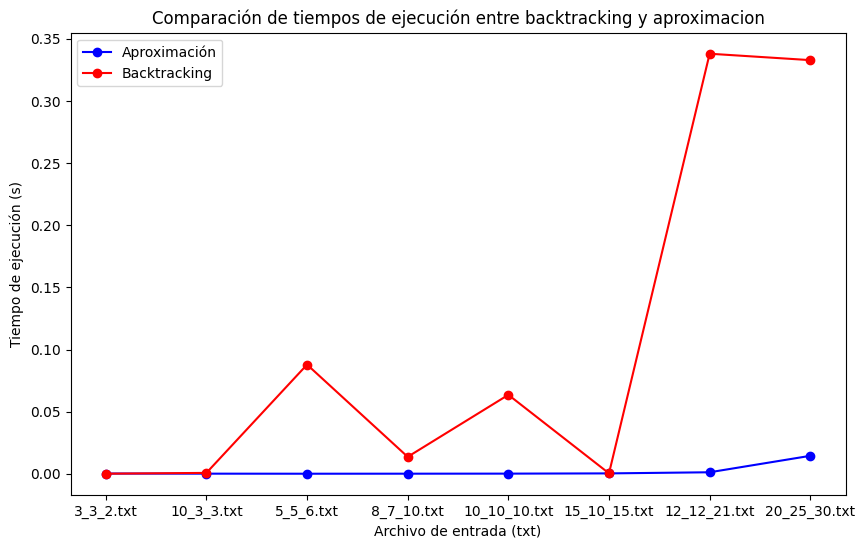

In [24]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

n_tamanios = ['3_3_2.txt', '10_3_3.txt', '5_5_6.txt', '8_7_10.txt' , '10_10_10.txt',  '15_10_15.txt','12_12_21.txt','20_25_30.txt']
tiempos_aprox = [0.00028371810913085938,0.00017786026000976562, 0.0001308917999267578, 0.00015664100646972656, 0.00020432472229003906, 0.00039577484130859375, 0.0012989044189453125,0.014533519744873047]
tiempos_exacto = [0.00014591217041015625, 0.0008003711700439453,0.08788490295410156, 0.01371312141418457,  0.06358575820922852, 0.0004355907440185547, 0.33794665336608887, 0.33278870582580566]
plt.figure(figsize=(10, 6))
plt.plot(n_tamanios, tiempos_aprox, 'o-', label="Aproximación", color='blue')
plt.plot(n_tamanios, tiempos_exacto, 'o-', label="Backtracking", color='red')

plt.xlabel('Archivo de entrada (txt)')
plt.ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.title("Comparación de tiempos de ejecución entre backtracking y aproximacion")
plt.show()



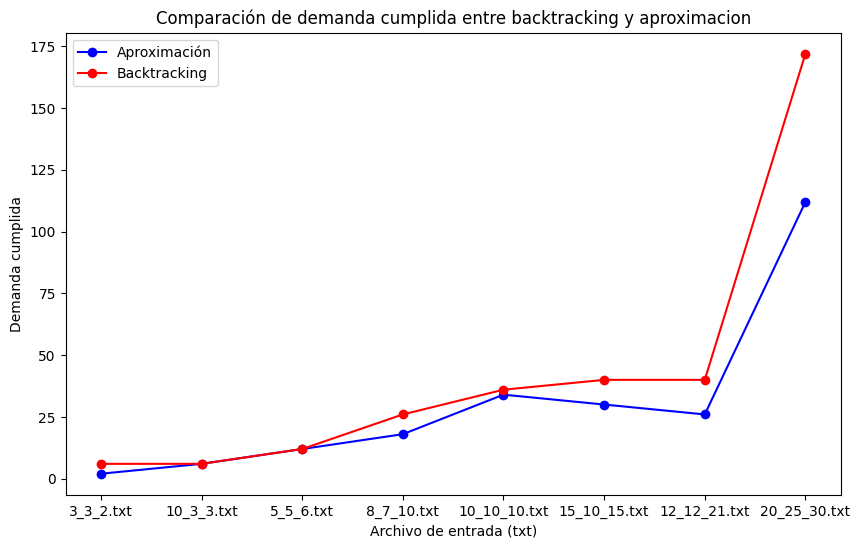

In [25]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

n_tamanios = ['3_3_2.txt', '10_3_3.txt', '5_5_6.txt', '8_7_10.txt' , '10_10_10.txt',  '15_10_15.txt','12_12_21.txt','20_25_30.txt']
tiempos_exacto = [6,6,12,26,36,40,40,172]
tiempos_aprox = [2,6, 12, 18, 34, 30 , 26,112]
plt.figure(figsize=(10, 6))
plt.plot(n_tamanios, tiempos_aprox, 'o-', label="Aproximación", color='blue')
plt.plot(n_tamanios, tiempos_exacto, 'o-', label="Backtracking", color='red')

plt.xlabel('Archivo de entrada (txt)')
plt.ylabel('Demanda cumplida')
plt.legend()
plt.title("Comparación de demanda cumplida entre backtracking y aproximacion")
plt.show()



In [26]:
m = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]

[[0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0]]